<a href="https://colab.research.google.com/github/Ahmed-Camara/cats-vs-dogs-classification/blob/main/cat_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

from IPython.display import clear_output
clear_output()

files.upload()

!mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats

!unzip dogs-vs-cats.zip
!unzip train.zip
!unzip test1.zip
!rm *.zip 
!rm -r sample_data

clear_output()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd  
import os 

import matplotlib.pyplot as plt 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,BatchNormalization,Dropout,Activation
from tensorflow.keras import Sequential

In [ ]:
# traing and test directories
train_dir = '/content/train'
test_dir = '/content/test1'

# Listing the contents of train and test directories. 
filenames = os.listdir(train_dir)
test_filenames = os.listdir(test_dir)

# generating the list of corresponding labels from train image filenames. 
labels = ['cat' if 'cat' in filename else 'dog' for filename in filenames]

# creating dataframe from filename and labels. 
train_df = pd.DataFrame({'filename': filenames, 'label': labels })
test_df = pd.DataFrame({'filename': test_filenames})
train_df.head()

,filename,label
0,cat.2894.jpg,cat
1,cat.2282.jpg,cat
2,dog.3437.jpg,dog
3,dog.8052.jpg,dog
4,cat.4489.jpg,cat


In [ ]:
train_df.to_csv('train.csv', index = False)

In [ ]:
# Hyperparameters
img_height = 224
img_width = 224
batch_size = 64
seed=42
data_generator = ImageDataGenerator(rescale=1./255,
                                    rotation_range=20,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.1,
                                    validation_split = 0.2,
                                    horizontal_flip = True,
                                    fill_mode='constant'
                                    )


train_set = data_generator.flow_from_dataframe(train_df,
                                                directory=train_dir,
                                                x_col = 'filename',
                                                y_col = 'label',
                                                target_size = (img_height, img_width),
                                                batch_size=batch_size,
                                                shuffle = True, 
                                               seed=seed,
                                                class_mode = 'binary',
                                                subset = 'training'
                                                )

valid_data = data_generator.flow_from_dataframe(train_df,
                                                directory=train_dir,
                                                x_col = 'filename', # image filename column
                                                y_col = 'label',    # image label column
                                                target_size = (img_height, img_width),
                                                batch_size=batch_size,
                                                seed = seed,
                                                shuffle = True, 
                                                class_mode = 'binary',
                                                subset = 'validation' # validation subsection
                                                )



classes = list(train_set.class_indices.keys())
classes

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


['cat', 'dog']

In [ ]:
test_generator = ImageDataGenerator(rescale=1./255)

test_set = test_generator.flow_from_dataframe(test_df, test_dir,
                                      x_col='filename',
                                      y_col=None,
                                      class_mode=None,
                                      target_size=(img_height, img_width),
                                      batch_size=batch_size,
                                      shuffle=False )

Found 12500 validated image filenames.


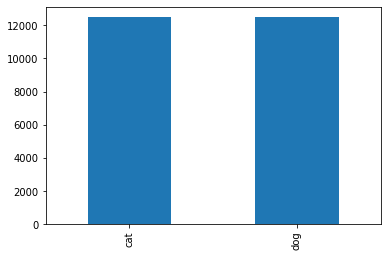

In [ ]:
train_df['label'].value_counts().plot.bar()

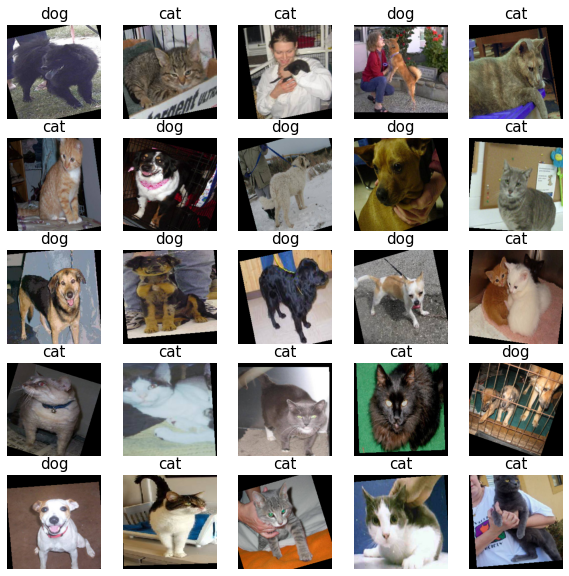

In [ ]:
X, y = train_set.next()

plt.figure(figsize = (10,10))
for i in range(25):
    ax = plt.subplot(5,5, i+1)
    plt.imshow(X[i])
    plt.title(classes[int(y[i])], fontdict={'fontsize': 15})
    plt.axis('off')

In [ ]:
model = tf.keras.Sequential([
        #block 1
        tf.keras.layers.Conv2D(32, kernel_size=(3,3),padding='same', input_shape=(img_height, img_width, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.25),

        #block 2
        tf.keras.layers.Conv2D(64,(3,3),padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((3,3)),

        #block 3
        tf.keras.layers.Conv2D(64,(3,3),padding='same'),
        tf.keras.layers.Conv2D(64,(3,3),padding='same'),
        tf.keras.layers.MaxPooling2D((2,2)), 
        tf.keras.layers.Dropout(0.25),

        #block 4
        tf.keras.layers.Conv2D(128,(3,3),padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        #block 5
        tf.keras.layers.Conv2D(256,(3,3),padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.25),

        #block 6
        tf.keras.layers.Conv2D(256,(3,3),padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(1,activation='sigmoid')
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      1

In [ ]:
file_path = '/content/drive/MyDrive/ML_DL_practice/cats-dogs-classification/temp/'
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
modelCheckPointer=tf.keras.callbacks.ModelCheckpoint(monitor='val_loss',
                                              filepath=file_path,
                                              save_best_only=True)

model.compile(optimizer ='adam',
              loss = 'binary_crossentropy', metrics = ['accuracy'])

#train model
history = model.fit(train_set, 
                    validation_data = valid_data,
                    batch_size=batch_size,
                    epochs = 50,
                    verbose = 1,callbacks=[stop_early,modelCheckPointer])

Epoch 1/50
313/313 [==============================] - 297s 910ms/step - loss: 0.6595 - accuracy: 0.6206 - val_loss: 0.8958 - val_accuracy: 0.4984
Epoch 2/50
313/313 [==============================] - 281s 899ms/step - loss: 0.5437 - accuracy: 0.7262 - val_loss: 0.5274 - val_accuracy: 0.7504
Epoch 3/50
313/313 [==============================] - 282s 901ms/step - loss: 0.4665 - accuracy: 0.7807 - val_loss: 0.4378 - val_accuracy: 0.7920
Epoch 4/50
313/313 [==============================] - 276s 883ms/step - loss: 0.3910 - accuracy: 0.8249 - val_loss: 0.6392 - val_accuracy: 0.6922
Epoch 5/50
313/313 [==============================] - 279s 892ms/step - loss: 0.3206 - accuracy: 0.8586 - val_loss: 0.2785 - val_accuracy: 0.8816
Epoch 6/50
313/313 [==============================] - 291s 931ms/step - loss: 0.2830 - accuracy: 0.8791 - val_loss: 0.5044 - val_accuracy: 0.7530
Epoch 7/50
313/313 [==============================] - 277s 886ms/step - loss: 0.2573 - accuracy: 0.8874 - val_loss: 0.3031 -

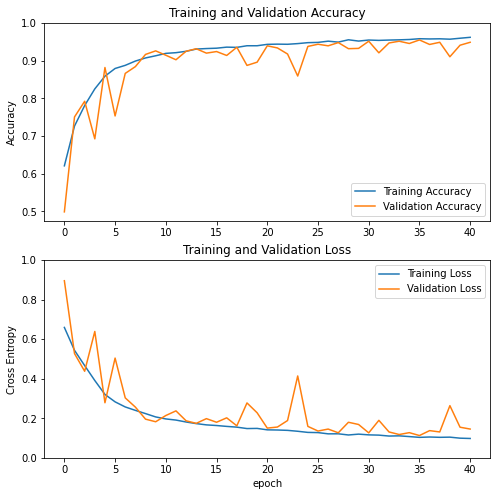

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Predict test sets

In [ ]:
from PIL import Image

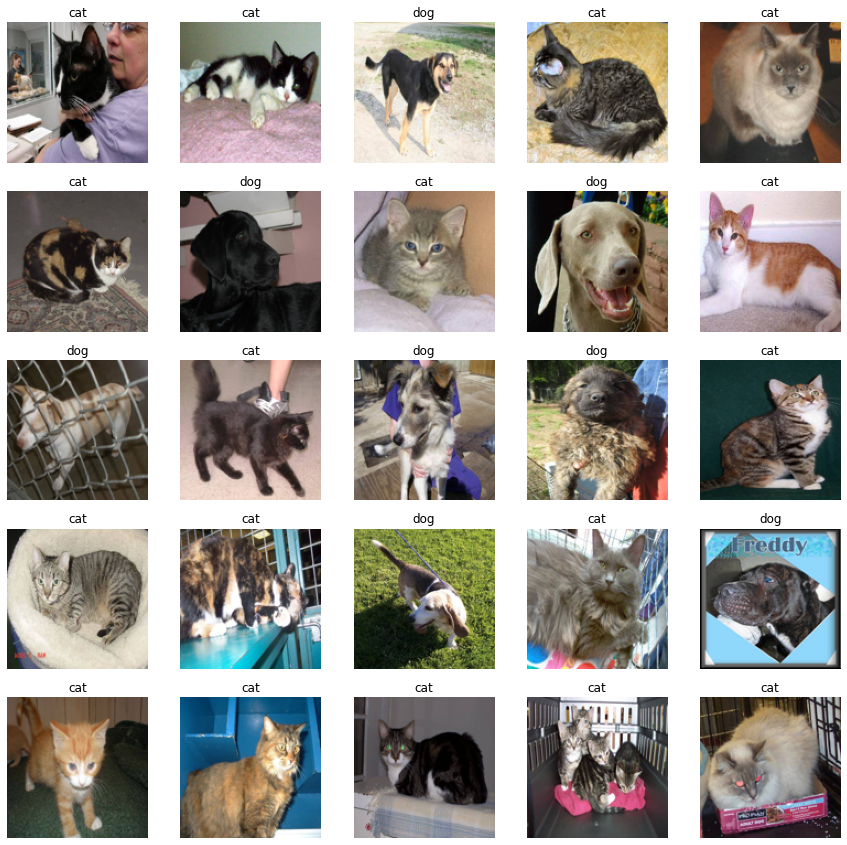

In [ ]:
predict_probs = model.predict(test_set)
y_pred =  (predict_probs > 0.5)*1
y_pred = y_pred.reshape(-1)


def load_image(filepath):
    img = Image.open(os.path.join(test_dir, filepath))
    img = img.resize((128,128))
    return np.array(img)

plt.figure(figsize = (15,15))
for i in range(25):
    ax = plt.subplot(5,5, i+1)
    plt.imshow(load_image(test_df.iloc[i,0]))
    plt.title(classes[int(y_pred[i])])
    plt.axis('off')

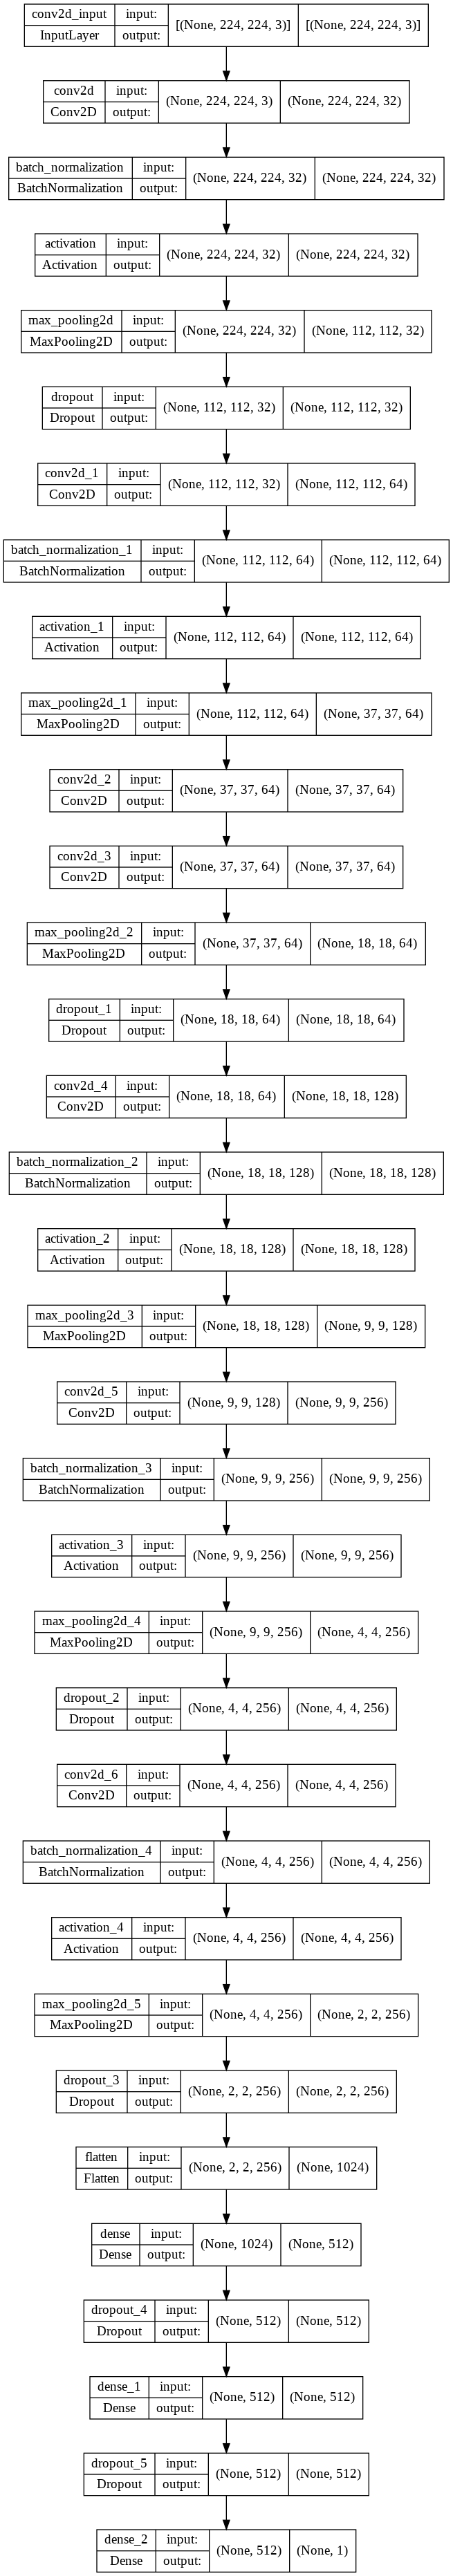

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
display(Image.open('model.png'))

## Test on single image

We will download two pictures on the internet for cat and dog.

<a href="https://images.unsplash.com/photo-1615789591457-74a63395c990?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8YmFieSUyMGNhdHxlbnwwfHwwfHw%3D&auto=format&fit=crop&w=600&q=60">cat picture</a>

<a href="https://ichef.bbci.co.uk/news/976/cpsprodpb/169A8/production/_120248529_gettyimages-157037529.jpg">dog picture</a>

In [ ]:
cat_pict = '/content/drive/MyDrive/ML_DL_practice/cats-dogs-classification/cat.jpeg'
dog_pict = '/content/drive/MyDrive/ML_DL_practice/cats-dogs-classification/dog.jpg'

Original shape: (224, 224, 3)
Input shape   : (1, 224, 224, 3)


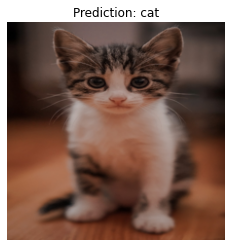

In [ ]:
img = Image.open(cat_pict)
img = img.resize((img_width, img_height))
img = np.array(img)
print(f'Original shape: {img.shape}')
img = img.reshape(1,img_width, img_height, 3)
print(f'Input shape   : {img.shape}')

# predcition
pred_probability = model.predict(img) 

%matplotlib inline
plt.imshow(img.reshape(img_height, img_width, 3))
plt.title(f'Prediction: {classes[int((pred_probability>0.5)*1)]}')
plt.axis('off')
plt.show()

Original shape: (224, 224, 3)
Input shape   : (1, 224, 224, 3)


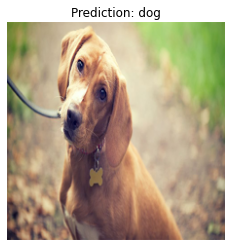

In [ ]:
img = Image.open(dog_pict)
img = img.resize((img_width, img_height))
img = np.array(img)
print(f'Original shape: {img.shape}')
img = img.reshape(1,img_width, img_height, 3)
print(f'Input shape   : {img.shape}')

# predcition
pred_probability = model.predict(img) 

%matplotlib inline
plt.imshow(img.reshape(img_height, img_width, 3))
plt.title(f'Prediction: {classes[int((pred_probability>0.5)*1)]}')
plt.axis('off')
plt.show()

In [ ]:
model_path = '/content/drive/MyDrive/ML_DL_practice/cats-dogs-classification/model'
model.save(model_path+'/cats_dogs.h5')